<a href="https://colab.research.google.com/github/swapnanilsharma/NLP-tasks-using-Deep-Learning/blob/master/Transfer_Learning_from_a_pretrained_model_from_Tensorflow_Hub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import required libraries**

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import os
import datetime
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Import dataset**

In [0]:
datasets, info = tfds.load(name='amazon_us_reviews/Major_Appliances_v1_00', with_info=True, batch_size=-1)

In [3]:
info

tfds.core.DatasetInfo(
    name='amazon_us_reviews',
    version=0.1.0,
    description='Amazon Customer Reviews (a.k.a. Product Reviews) is one of Amazons iconic products. In a period of over two decades since the first review in 1995, millions of Amazon customers have contributed over a hundred million reviews to express opinions and describe their experiences regarding products on the Amazon.com website. This makes Amazon Customer Reviews a rich source of information for academic researchers in the fields of Natural Language Processing (NLP), Information Retrieval (IR), and Machine Learning (ML), amongst others. Accordingly, we are releasing this data to further research in multiple disciplines related to understanding customer product experiences. Specifically, this dataset was constructed to represent a sample of customer evaluations and opinions, variation in the perception of a product across geographical regions, and promotional intent or bias in reviews.

Over 130+ million cus

In [0]:
dataset = tfds.as_numpy(datasets['train'])

Converting target variable to binary


In [0]:
@tf.function
def target(x):
  if x > 3:
    return 1
  else:
    return 0

In [0]:
X = dataset['data']['review_body']
y = np.vectorize(target)(dataset['data']['star_rating'])

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [0]:
embedding = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, output_shape=[128], trainable=True)

In [9]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 32)                4128      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 124,646,849
Trainable params: 124,646,849
Non-trainable params: 0
_________________________________________________________________


In [0]:
model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])

In [11]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=2, verbose=1, batch_size=512)

Epoch 1/2
152/152 [==============================] - 205s 1s/step - loss: 0.5465 - accuracy: 0.8045 - val_loss: 0.5014 - val_accuracy: 0.8826
Epoch 2/2
152/152 [==============================] - 207s 1s/step - loss: 0.4916 - accuracy: 0.8951 - val_loss: 0.4940 - val_accuracy: 0.8850


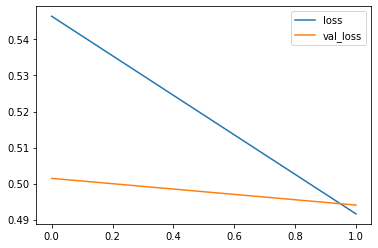

In [12]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

In [13]:
results = model.evaluate(X_test, y_test, batch_size=512, verbose=True)
print(results)

38/38 [==============================] - 6s 162ms/step - loss: 0.4940 - accuracy: 0.8850
[0.4940117299556732, 0.8849904537200928]


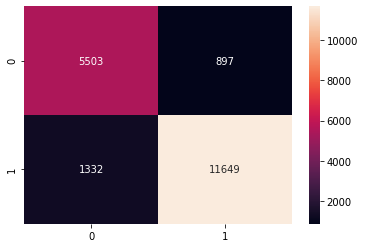

In [14]:
y_pred=tf.where(model.predict(X_test)>0.5, 1, 0)
cf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cf_matrix, annot=True, fmt="d")
plt.show()